In [46]:
import os
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.stats import pearsonr

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from playsound import playsound
from shapely.geometry import box

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import DOWN_raw

import warnings
warnings.filterwarnings('ignore')

In [2]:
yy_s, yy_e = 2002, 2012
# yy_s, yy_e = 2007, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)

Extract Parameters for: 2002 to 2012


In [8]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, YYS_, YYE_, NY_ = [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'YYS', YYS_)
new_df.insert(4, 'YYE', YYE_)
new_df.insert(5, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

In [9]:
lon_min_rect, lon_max_rect = lon_min, lon_max
lat_min_rect, lat_max_rect = lat_min, lat_max

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [10]:
# =============================================================================
wa_gdf = gpd.GeoDataFrame(clear_df, geometry=gpd.points_from_xy(clear_df['Lon'], clear_df['Lat']), crs="EPSG:4326")
wa_inside_rect = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect = wa_inside_rect.drop(columns=['index_right'])

# =============================================================================
wa_inside_rect = wa_inside_rect[wa_inside_rect['Q50']<=600]
wa_inside_rect = wa_inside_rect.reset_index(drop=True)

wa_inside_rect.sort_values(by=["Lat", "Lon"], ascending=[True, True], inplace=True)

# QOBS_area_mean = np.nanmean(wa_inside_rect.iloc[:,6:-1].values,axis=0)

## Filter using a circle

In [72]:
lon_c, lat_c = wa_inside_rect['Lon'][0], wa_inside_rect['Lat'][0]
radio = 0.2

circle = Point(lon_c, lat_c).buffer(radio)
circle_gdf = gpd.GeoDataFrame(geometry=[circle], crs="EPSG:4326")

# Convertir estaciones a geometría de puntos
wa_inside_rect['geometry'] = wa_inside_rect.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
stations_gdf = gpd.GeoDataFrame(wa_inside_rect, geometry='geometry', crs="EPSG:4326")

# Filtrar estaciones dentro del círculo
stations_inside = stations_gdf[stations_gdf.geometry.within(circle)]

In [79]:
distances = []

for (idx1, row1), (idx2, row2) in itertools.combinations(stations_inside.iterrows(), 2):
    file1, lat1, lon1 = row1['File_Name'], row1['Lat'], row1['Lon']
    file2, lat2, lon2 = row2['File_Name'], row2['Lat'], row2['Lon']

    # Leer los datos de las estaciones
    data1 = pd.read_csv(os.path.join(OBS_base,'Veneto','DATA','1dy_Flag',file1))
    data1['date'] = pd.to_datetime(data1['date'])
    data1_filter = data1[(data1['date'].dt.year >= yy_s) & (data1['date'].dt.year <= yy_e)]

    data2 = pd.read_csv(os.path.join(OBS_base,'Veneto','DATA','1dy_Flag',file2))
    data2['date'] = pd.to_datetime(data2['date'])
    data2_filter = data2[(data2['date'].dt.year >= yy_s) & (data2['date'].dt.year <= yy_e)]

    cor, _ = pearsonr(data1_filter['Prec_diario'].values,data2_filter['Prec_diario'].values)  # Suponiendo que la segunda columna tiene los datos
    dist = DOWN_raw.haversine(lat1, lat2, lon1, lon2)

    distances.append({'Station_1': idx1, 'Station_2': idx2, 'Distance_km': dist, 'Corr': cor})

df_distances = pd.DataFrame(distances)

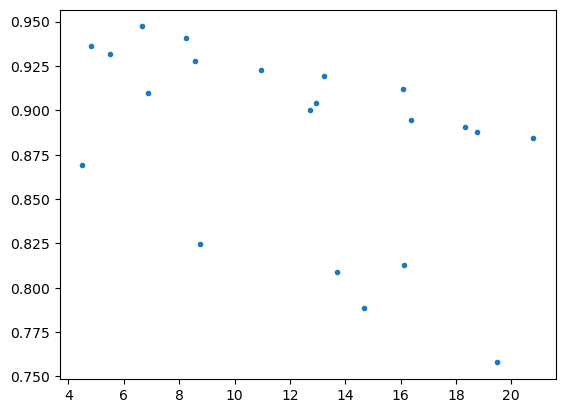

In [80]:
plt.plot(df_distances['Distance_km'],df_distances['Corr'],'.')

In [75]:
for nn in range(1):
    obs_tmp = pd.read_csv(os.path.join(OBS_base,'Veneto','DATA','1dy_Flag',wa_inside_rect['File_Name'][nn]))
    obs_tmp['date'] = pd.to_datetime(obs_tmp['date'])
    obs_filtered = obs_tmp[(obs_tmp['date'].dt.year >= yy_s) & (obs_tmp['date'].dt.year <= yy_e)]


Text(0.0, 1.0, 'OBS Quantiles (Tr = 50 yrs)')

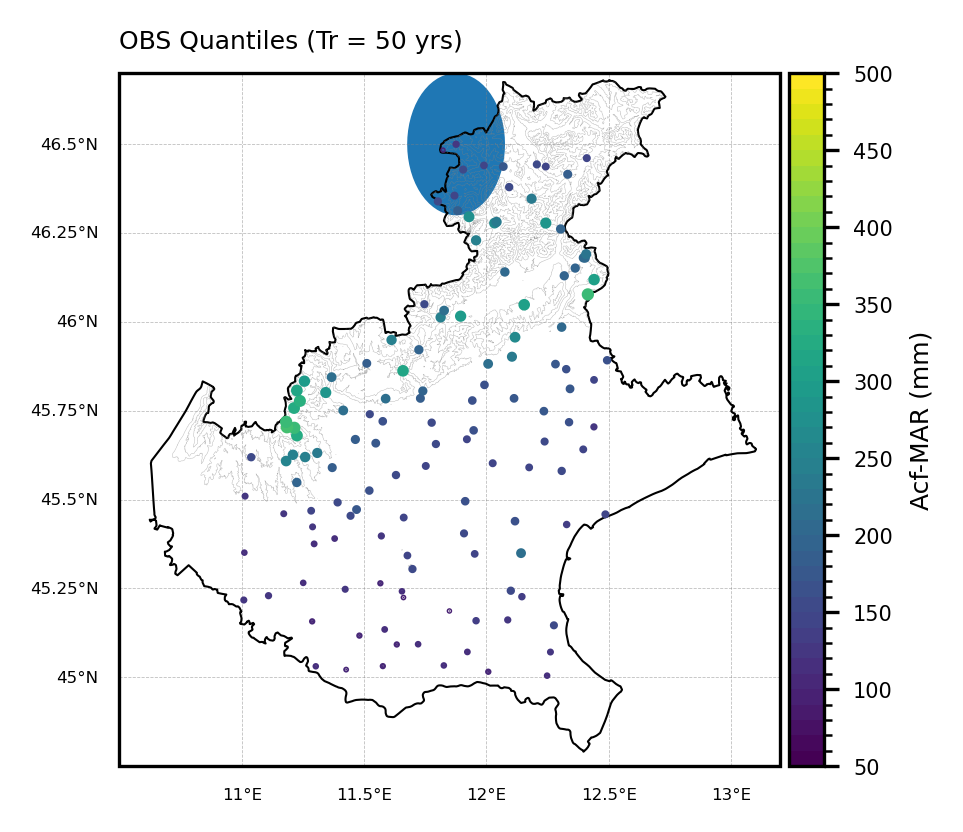

In [76]:
Q50_obs_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

# a1 = ax1.scatter(lon2d, lat2d,
#                 s = (Mevd_mar-np.min(Mevd_mar))/(np.max(Mevd_mar)-np.min(Mevd_mar))*5, 
#                 c = Mevd_mar,
#                 marker='s',
#                 norm=norm_obs)

# rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.5, zorder=15)
a1 = ax1.scatter(
                wa_inside_rect['Lon'].values, 
                wa_inside_rect['Lat'].values, 
                s=Q50_obs_norm*4, 
                c=wa_inside_rect['Q50'], 
                norm=norm_obs,
                zorder=20, label='Stations')

circle_gdf.plot(ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=5)
cbar.set_label("Acf-MAR (mm)", fontsize=6)

ax1.set_title(f'OBS Quantiles (Tr = 50 yrs)', fontsize=6, loc='left')

# =========================================================================================================================
# salida = os.path.join('/','home','arturo','Pictures','VALIDATION',f'OBS_ACF_param.png')
# print(f'Export figure to: {salida}')
# # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)